In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sys import argv
# first we import the test6 set
file_name = "2ionsfixed.txt"
dat_1 = np.loadtxt(file_name)
#wz, ions, collided, offset, reorder = zip(data_file_1)
try:

    if len(argv) > 1:
        data_file = argv[1]

    # Load data from file:

    dat_1 = np.loadtxt(file_name)
    velocity = dat_1[:,1]     
    ions = dat_1[:,2]
    collided = dat_1[:,3] # ion collided with
    offset = dat_1[:,4]   # offset of colliding particle
    reorder = dat_1[:,5] #did reorder occur

except IOError:
    print("** Error reading specified file - aborting **")
    exit()
    
v = []; sigmaR = []; sigmaRunc = [];

for i in range(len(velocity)-1):
    if (reorder[i] == 0 and reorder[i+1] == 0) and (velocity[i] == velocity[i+1]):
        v.append(velocity[i])
        sigmaR.append((offset[i]+offset[i-1])/2)
        sigmaRunc.append((offset[i]-offset[i-1])/2)
print(len(v))
#data is [impact speed, reorder cross section (maximum distance that we still see reorder), uncertainty]
print(np.min(v))

145
377.8523489932886


In [203]:
# Here we define a function that returns a normalized boltzman distribution (3D version) binned to 50,100,....5000
from scipy import special
def Boltz(m,T,vmin=0,vmax=5000,bins=100):
    k = 1.386e-23 # boltzmann constant
    boltz = np.zeros(bins) # initialize vector
    dv = (vmax - vmin)/bins # define bin spacing in speed
    a = (k*T/m)**(1/2) # normalization constant for distribution function

    
    for i in range(bins):
        vhere = vmin + i*dv # define speed of bin
        vlast = vhere-dv
        boltz[i] = (special.erf(vhere/(a*np.sqrt(2))) - np.sqrt(2/np.pi)*(vhere/a)*np.exp(-vhere**2/(2*a**2)) ) - (special.erf(vlast/(a*np.sqrt(2))) - np.sqrt(2/np.pi)*(vlast/a)*np.exp(-vlast**2/(2*a**2)) ) # here we use the cumulative distribution function and subtract the one-step down value from the this step value for the probability density in this slice
    
    return boltz/np.sum(boltz) #return normalized vector

1.0
1.2796069604980421e-09
6.711409395973168e-12


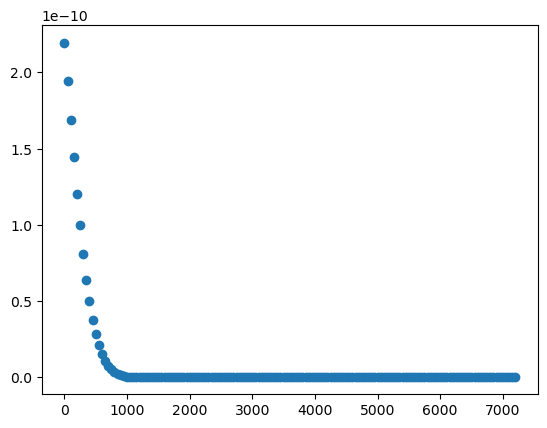

In [205]:
# we test our normalized boltzmann distribution
length = len(v)
min_v = np.min(v)
max_v = np.max(v)
amu = 1.66*10**-27 # kg
Temp = 300
boltz = Boltz(40*amu,Temp,min_v,max_v,length)
#plt.scatter([x*50 for x in range(length)],boltz)
print(np.sum(boltz))
sigmaT = boltz*sigmaR
sigmaTUnc = boltz*sigmaRunc
#plt.plot([x*50 for x in range(length)],sigmaT)
plt.errorbar([x*50 for x in range(length)],sigmaT,yerr = sigmaTUnc,fmt = "o")
print(sum(sigmaT))
print(sum(sigmaTUnc))

/var/folders/05/0dpn5_412rnb00kqwtk9gb4h0000gn/T/ipykernel_14874/4234426578.py:15: RuntimeWarning: invalid value encountered in divide
  return boltz/np.sum(boltz) #return normalized vector


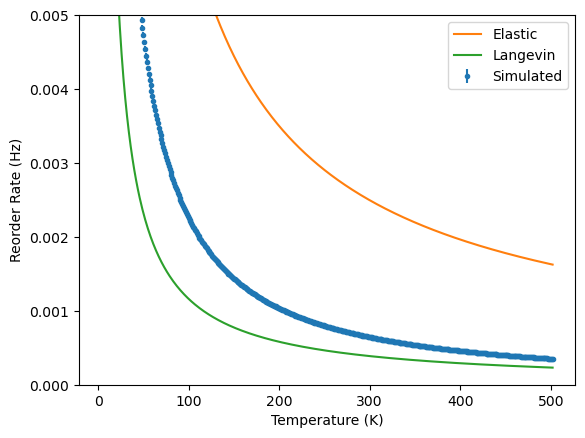

In [207]:
# Now that we know our reorder rates scale sensibly and our reorder probabilities appear to make sense
# Let's do re-order rate as a function of Temperature
nTemps = 500
startTemp = 4
sigRT = np.zeros(nTemps)
sigRTUnc = np.zeros(nTemps)
rateOfTemp = np.zeros(nTemps)
rateOfTempUnc = np.zeros(nTemps)
vs = np.linspace(min_v,max_v,length)
A = 1.0 # pi*((r[1] - r[8000]))^2 # in m but I already wrapped area up in my earlier calc
k = 1.386e-23 # boltzmann constant
P = 1e-9 # let's just assume a pressure of about 1e-11 torr/mbar which is 1e-9 torr
#vave = np.sum(range(1,100).*50.0.*boltz) # gives the average speed for collision frequency

for i in range(nTemps):
    #iterate all temperatures
    Temp = startTemp + (i+1)
    #generate the boltzman distribution based on the temperature and the minimum/maximum velocity
    boltz = Boltz(40*amu,Temp,min_v,max_v,length) # these are the weights for our average reordering rate
    vave = np.sum(vs*boltz) # calculates the average velocity at the given temperature
    sigmaT = boltz*sigmaR
    sig = np.sum(sigmaT) # complete weighted average
    sigmaTUnc = boltz*sigmaRunc
    sigUnc = np.sum(sigmaTUnc) # complete weighted average of errors
    reorderRate = 1.0*(P/(k*Temp))*(np.pi*sig**2)*vave # calculates the reorder rate based on pvnrt and the average velcoity at the given temperature
    #this is n*A*v with the circular cross-section giving A
    reorderUnc = 1.0*(P/(k*Temp))*(np.pi*2*sig*sigUnc)*vave # this is n*A*v with the circular cross-section giving A
       
    # To calculate the reorder rate we first calculate the temperature reorder cross-section and the average velocity
    # of the background hydrogen using the boltzmann distribution and our simulated cross-section. 
    # Using PV/kT = N we can solve for the amount of background hydrogen at a given pressure and temperature.
    # Then using the formula N*sig*average_v, where sig is the weighted average of the temperature reorder cross-section,
    # we can calculate the reorderRate in Hz.
        
    # assign values
    sigRT[i]= sig # cross-section radius
    sigRTUnc[i]= sigUnc # cross-section radius uncertainty
    rateOfTemp[i] = reorderRate
    rateOfTempUnc[i] = reorderUnc


#sigE = 5.08 * (mu*C4/(hbar^2*k*Temp))^(1/3)
#sigL = pi * (2*C4/(k*Temp))^(1/2) # rates are n*v*sigma where n is P/kT and v is sqrt(8kT/pi*m)
T = np.linspace(4,nTemps+3,nTemps+3-4)
theoryRateE = 2.5e-3 * (T/300)**(-5/6) # for elastic collision rate
theoryRateL = 3.88e-4 * (T/300)**(-1) # for langevin collision rate


#plot(range(1,nTemps).*1.0,fractOfTemp)
#plt.plot(range(3,503),rateOfTemp, label = "Simulated") 
plt.errorbar(range(3,503),rateOfTemp,yerr = rateOfTempUnc,fmt = ".",label = "Simulated")
plt.plot(range(4,503),theoryRateE, label = "Elastic")
plt.plot(range(4,503),theoryRateL, label = "Langevin")
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Reorder Rate (Hz)")
#plt.ylim(0,2)
#ax = gca()
#plt.xlim(0.0,0.7e-4)
plt.ylim(0.0,0.5e-2)
plt.show()
#title("Test Title")
#println("P = ",P)
#println("vave = ",vave)
#println("A = ",A)
#println(rateOfTemp)
# typically used cross-sections
